# Fragment Assembly

> Fragment assembly related functions

In [ ]:
#| default_exp fragment_assembly

In [ ]:
#| hide
from nbdev.showdoc import *
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
from chem_templates.imports import *
from chem_templates.utils import *
from chem_templates.chem import Molecule, to_smile, to_mol
from chem_templates.template import Template, TemplateResult
from chem_templates.fragment import get_dummy_mol, generate_mapping_permutations, combine_dummies, \
    fuse_smile_on_atom_mapping, is_mapped

/home/dmai/miniconda3/envs/chem_templates/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#| export

def visualize_assembly(molecule: Molecule) -> str:
    
    source = molecule.data['source']
    
    if 'template_result' in molecule.data.keys():
        template_result = 'Pass' if molecule.data['template_overall'] else 'Fail'
        template_result = f', Template {template_result}'
    else:
        template_result = ''
    
    if 'input_smiles' in molecule.data.keys():
        rep_str = f"{source}, {molecule.data['input_smiles']} -> {molecule.smile}{template_result}"
        rep_str += '\n'
        for source in molecule.data['source_molecules']:
            rep_str += '\n\t' + '\n\t'.join(visualize_assembly(source).split('\n'))
        return rep_str
    else:
        return f"{source}, {molecule.smile}{template_result}"
    

In [ ]:
#| export

class FragmentNode():
    def __init__(self, 
                 name: str, 
                 template: Template=None):
        self.name = name
        self.template = template
        self.id = 1
        self.build_ids()
        self.build_dummies()
        
    def template_screen(self, molecule: Molecule, store_data=True):
        if self.template is not None:
            output = self.template(molecule)
        else:
            output = TemplateResult(True, [], [])
        
        if store_data:
            molecule.add_data({'template_data' : output, 'template_result' : output.result})
            
        return output
    
    def fragment_screen(self, fragment: str):
        if self.match_mapped_fragment(fragment):
            molecule = Molecule(fragment)
            template_result = self.template_screen(molecule, store_data=False)
            return template_result.result
        else:
            return False
        
    def match_unmapped_fragment(self, fragment):
        return fragment.count('*') == self.dummy_smile.count('*')
    
    def match_mapped_fragment(self, fragment):
        patt = re.compile('\[\*(.*?)]')
        frag_idxs = sorted([int(i[1:]) for i in patt.findall(fragment)])
        return frag_idxs == self.mapping_idxs
    
    def get_leaf_nodes(self):
        outputs = {}
        stack = [self]
        while stack:
            current = stack.pop()
            
            if hasattr(current, 'children'):
                for child in current.children:
                    stack.append(child)
            else:
                outputs[current.name] = current
                
        return outputs
        
    def build_dummy(self):
        self.dummy_smile = ''
        
    def build_ids(self):
        stack = [self]
        current_id = 1
        while stack:
            current = stack.pop()
            current.id = current_id
            current_id += 1
            
            for child in getattr(current, 'children', []):
                stack.append(child)
                
    def build_dummies(self):
        for child in getattr(self, 'children', []):
            child.build_dummies()
            
        self.build_dummy()
        
    def repr_swap(self, input_str):
        input_str = input_str.replace(f'Zr:{self.id}', self.name)
        if hasattr(self, 'children'):
            for child in self.children:
                input_str = child.repr_swap(input_str)
                
        return input_str
        
    def __repr__(self):
        rep_str = f'{self.name}: {self.repr_swap(self.dummy_smile)}'
        if hasattr(self, 'children'):
            rep_str += '\n'
            for child in self.children:
                rep_str += '\n\t' + '\n\t'.join(child.__repr__().split('\n'))
                
        return rep_str

In [ ]:
#| export

class FragmentLeafNode(FragmentNode):
    def __init__(self, 
                 name: str, 
                 mapping_idxs: list[int], 
                 template: Template=None):
        
        self.mapping_idxs = sorted(mapping_idxs)
        super().__init__(name, template)
        
    def build_dummy(self):
        self.dummy = get_dummy_mol(self.name, self.mapping_idxs, id=self.id)
        self.dummy_smile = to_smile(self.dummy)
        
    def match_and_map(self, fragment):
        outputs = []
        if is_mapped(fragment):
            if self.match_mapped_fragment(fragment):
                outputs = [fragment]
        elif self.match_unmapped_fragment(fragment):
            outputs = generate_mapping_permutations(fragment, self.mapping_idxs, exact=True)
            
        return outputs
        
    def assemble(self, assembly_dict):
        node_data = {'source' : self.name}
        molecule = Molecule(assembly_dict.get(self.name, ''), data=node_data)
        template_result = self.template_screen(molecule)
        
        molecule.add_data({'template_overall' : template_result.result})
        assembly_str = visualize_assembly(molecule)
        molecule.add_data({'assembly_string' : assembly_str})
        return molecule

In [ ]:
R1 = FragmentLeafNode('R1', [1])
scaffold = FragmentLeafNode('Scaffold', [1, 2])

assert R1.match_unmapped_fragment('*C')
assert not R1.match_unmapped_fragment('*C*')
assert R1.match_mapped_fragment('[*:1]C')
assert not R1.match_mapped_fragment('*C')
assert scaffold.match_unmapped_fragment('*C*')
assert scaffold.match_and_map('*C*') == ['[*:1]C[*:2]', '[*:2]C[*:1]']

In [ ]:
#| export

class ConstantFragmentNode(FragmentNode):
    def __init__(self, 
                 name: str, 
                 fragment_smiles: str):
        
        assert is_mapped(fragment_smiles), "fragment_smiles must be mapped"
        
        patt = re.compile('\[\*(.*?)]')
        self.mapping_idxs = sorted([int(i[1:]) for i in patt.findall(fragment_smiles)])
        self.fragment_smiles = fragment_smiles
        self.dummy_smile = fragment_smiles
        self.dummy = to_mol(self.dummy_smile)
        super().__init__(name, None)
        
    def build_dummy(self):
        pass
    
    def match_and_map(self, fragments):
        return []
    
    def match_unmapped_fragment(self, fragment):
        return False
    
    def match_mapped_fragment(self, fragment):
        return False
        
    def assemble(self, assembly_dict):
        if assembly_dict.get(self.name, ''):
            warnings.warn(
                f"warning: fragment {assembly_dict.get(self.name, '')} routed to constant node {self.name}")
            
        node_data = {'source' : self.name}
        molecule = Molecule(self.fragment_smiles, data=node_data)
        assembly_str = visualize_assembly(molecule)
        molecule.add_data({'assembly_string' : assembly_str})
        return molecule

In [ ]:
R2 = ConstantFragmentNode('R2', '[*:2]c1ccccc1')
R2

R2: [*:2]c1ccccc1

In [ ]:
#| export

class AssembledFragmentNode(FragmentNode):
    def __init__(self, 
                 name: str, 
                 children: list[FragmentNode], 
                 template: Template=None):
        
        self.children = children
        super().__init__(name, template)
        
    def build_dummy(self):
        self.dummy = combine_dummies([child.dummy for child in self.children])
        self.dummy_smile = to_smile(self.dummy)
        patt = re.compile('\[\*(.*?)]')
        self.mapping_idxs = sorted([int(i[1:]) for i in patt.findall(self.dummy_smile)])
        
    def assemble(self, assembly_dict):
        
        child_molecules = [child.assemble(assembly_dict) for child in self.children]
        input_smiles = '.'.join([i.smile for i in child_molecules])
        fused_smile = fuse_smile_on_atom_mapping(input_smiles)
        
        node_data = {
                    'source' : self.name,
                    'source_molecules' : child_molecules,
                    'input_smiles' : input_smiles
                    }
        
        molecule = Molecule(fused_smile, data=node_data)
        template_result = self.template_screen(molecule)
        
        prev_templates = [child.data.get('template_overall', True) for child in child_molecules]
        
        molecule.add_data({'template_overall' : template_result.result and all(prev_templates)})
        assembly_str = visualize_assembly(molecule)
        molecule.add_data({'assembly_string' : assembly_str})
        return molecule

In [ ]:
Assembled = AssembledFragmentNode('Assembled', [R1, scaffold, R2])
Assembled

Assembled: c1ccc([Scaffold][R1])cc1

	R1: [*:1][R1]
	Scaffold: [*:1][Scaffold][*:2]
	R2: [*:2]c1ccccc1

In [ ]:
assembly_dict = {
    'R1' : '[*:1]C',
    'Scaffold' : '[*:1]c1cnc([*:2])cc1'
}
res = Assembled.assemble(assembly_dict)

In [ ]:
res.data['source_molecules'][0].data

{'source': 'R1',
 'template_data': <chem_templates.template.TemplateResult>,
 'template_result': True,
 'template_overall': True,
 'assembly_string': 'R1, C[*:1], Template Pass'}

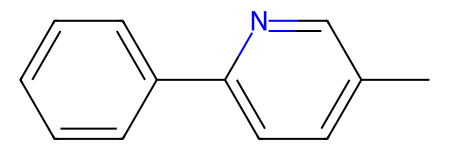

In [ ]:
res.mol

In [ ]:
print(res.data['assembly_string'])

Assembled, C[*:1].c1cc([*:2])ncc1[*:1].c1ccc([*:2])cc1 -> Cc1ccc(-c2ccccc2)nc1, Template Pass

	R1, C[*:1], Template Pass
	Scaffold, c1cc([*:2])ncc1[*:1], Template Pass
	R2, c1ccc([*:2])cc1


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()